In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# !unzip gdrive/My\ Drive/3D_Digits/CSV_Files.zip

## Importing Functions

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle

## Data Visualisation

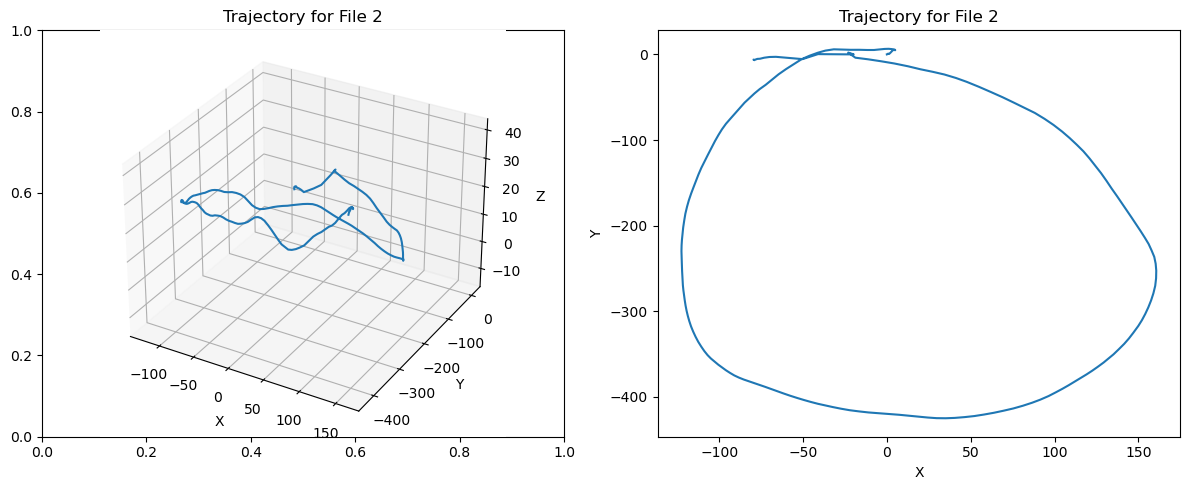

In [4]:
def read_and_preprocess_3d_data(folder_path, n_nearest_neighbor_normalization=5):
    """
    Read and preprocess 3D data from a folder of CSV files primarily for visualisation.

    Parameters:
    - folder_path (str): The path to the folder containing CSV files.
    - n_nearest_neighbor_normalization (int): The window size for nearest neighbor normalization.

    Returns:
    - pd.DataFrame: 3D DataFrame with preprocessed data.
    - np.array: Array of labels corresponding to the data.
    """
    data_list = []
    label_list = []

    # Preprocessing functions
    def root_point_normalization(data):
        """
        Normalize the data by subtracting the first value from each element.

        Parameters:
        - data (pandas.DataFrame): Input data.

        Returns:
        - pandas.DataFrame: Normalized data.
        """
        return data - data.iloc[0]

    def nearest_neighbor_normalization(data, n_neighbors):
        """
        Perform nearest-neighbor normalization on the data.

        Parameters:
        - data (pandas.DataFrame): Input data.
        - n_neighbors (int): Number of neighbors for the rolling mean.

        Returns:
        - pandas.DataFrame: Normalized data.
        """
        return data.rolling(window=n_neighbors, min_periods=1).mean()

    # Iterate through each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)

            # Extract label from file name
            label = int(file_name.split('_')[1])

            # Read CSV file into a pandas DataFrame
            df = pd.read_csv(file_path, header=None, names=["X", "Y", "Z"])

            # Apply root point normalization
            df[["X", "Y", "Z"]] = root_point_normalization(df[["X", "Y", "Z"]])

            # Apply nearest neighbor normalization
            df[["X", "Y", "Z"]] = nearest_neighbor_normalization(df[["X", "Y", "Z"]], n_nearest_neighbor_normalization)

            # Append the DataFrame to the list
            data_list.append(df)
            label_list.append(label)

    # Convert the list of DataFrames into a 3D pandas DataFrame
    df_3d = pd.concat(data_list, keys=range(len(data_list)), names=["File", "Row"])

    return df_3d, np.array(label_list)

# Specify the folder and read the data:
folder_path = "training_data" # input path to folder containing training data
df_3d, label_array = read_and_preprocess_3d_data(folder_path)
# Select particular csv file and get its trajectory information
file_idx = 2
selected_data = df_3d.xs(key=file_idx, level="File")
# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot the 3D trajectory in the first subplot
ax1 = axs[0]
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(selected_data["X"], selected_data["Y"], selected_data["Z"])
ax1.set_title(f"Trajectory for File {file_idx}")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
# Plot the 2D trajectory in the second subplot
ax2 = axs[1]
ax2.plot(selected_data["X"], selected_data["Y"])
ax2.set_title(f"Trajectory for File {file_idx}")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
plt.tight_layout()
plt.show()

In [2]:

# Normalize a sequence of 3D points using nearest neighbor averaging
def nearest_neighbor_point_normalization(points, n=5):
    """
    Normalize a sequence of 3D points using nearest neighbor averaging.

    Parameters:
    - points: 3D point sequence
    - n: Number of previous points to consider for averaging (default is 5)

    Returns:
    - Normalized sequence of 3D points
    """
    points_normalized = []

    for i in range(len(points)):
        # Determine the start index for averaging, ensuring it doesn't go below 0
        id_start = max(0, i - n + 1)

        # Extract the subset of points to be averaged
        subset = points[id_start:i + 1]

        # Compute the average point, considering only x, y, and z coordinates
        point_average = np.mean(subset, axis=0)

        # Append the averaged point to the normalized sequence
        points_normalized.append(point_average[:3])

    return np.array(points_normalized)

# Normalize a sequence of 3D points by subtracting the root point.
def root_point_normalization(points):
    """
    Normalize a sequence of 3D points by subtracting the root point.

    Parameters:
    - points: 3D point sequence

    Returns:
    - Normalized sequence of 3D points
    """
    # Get the root point (first point in the sequence)
    root_point = points[0]

    # Subtract the root point from all points in the sequence
    return points - root_point

# Pad a sequence with a specified padding value to reach a maximum length.
def pad_sequence(sequence, max_length=221, padding_value=0):
    """
    Pad a sequence with a specified padding value to reach a maximum length.

    Parameters:
    - sequence: Input sequence
    - max_length: Desired maximum length of the sequence
    - padding_value: Value to use for padding (default is 0)

    Returns:
    - Padded sequence
    """
    # Create a matrix filled with the padding value, with dimensions (max_length, num_features)
    padded_sequence = np.full((max_length, sequence.shape[1]), padding_value)

    # Copy the input sequence to the end of the padded sequence
    padded_sequence[-len(sequence):] = sequence

    return padded_sequence


In [3]:

# Maximum length for padding the trajectories
max_length = 221

# Step 1: Data Loading and Preprocessing
data = "training_data"  # input path to folder containing training data
files = os.listdir(data)

X = []  # List to store padded trajectories
y = []  # List to store digit labels

for file in files:
    if file.endswith(".csv"):
        # Extract digit label from the file name (assuming the file name format is "stroke_{digit}_{index}.csv")
        digit = int(file.split("_")[1])

        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(data, file))

        # Append the digit label to the y list
        y.append(digit)

        # Extract 3D location from the DataFrame
        location = df.values[:, :3]

        # Normalize the location using nearest neighbor averaging and root point normalization
        normalized_location = nearest_neighbor_point_normalization(location)
        normalized_location = root_point_normalization(normalized_location)

        # Pad the normalized location to the specified maximum length
        padded_location = pad_sequence(normalized_location, max_length)

        # Append the padded location to the X list
        X.append(padded_location)


In [6]:
# Flatten the padded sequences for each observation

X = np.array(X)  # Convert the list of padded trajectories to a NumPy array
X = X.reshape(X.shape[0], -1)  # Flatten the 2D array to a 1D array for each observation
y = np.array(y)  # Convert the list of digit labels to a NumPy array

# Step 3: Train-Test Split
# Split the data into training and testing sets using stratified sampling
# Stratified sampling ensures that the distribution of digit labels is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.05)


Epoch 0, Loss: 2.6211565881610315
Epoch 100, Loss: 0.12010872023839557
Epoch 200, Loss: 0.04167393772947367
Epoch 300, Loss: 0.02250196705868823
Epoch 400, Loss: 0.01471159432811079
Epoch 500, Loss: 0.010683573325890712
Epoch 600, Loss: 0.008270858260598162
Epoch 700, Loss: 0.006677776062684484
Epoch 800, Loss: 0.005564378741238908
Epoch 900, Loss: 0.00474418243728974


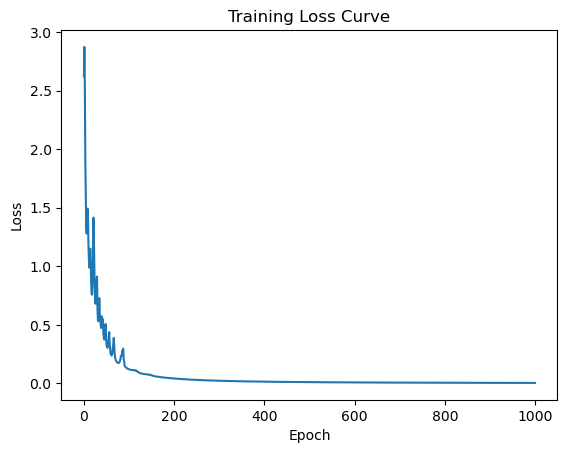

Model saved as model.pkl
Model loaded from model.pkl
Test Accuracy: 0.96


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.parameters = self.initialize_parameters()

    # Activation function: Rectified Linear Unit (ReLU)
    def relu(self, x):
        """
        Compute the Rectified Linear Unit (ReLU) activation.

        Parameters:

        - x: Input data

        Returns:
        - Activated output
        """
        return np.maximum(0, x)

    # Derivative of ReLU for backpropagation
    def relu_derivative(self, x):
        """
        Compute the derivative of the Rectified Linear Unit (ReLU) activation.

        Parameters:
        - x: Input data

        Returns:
        - Derivative of the activation
        """
        return np.where(x > 0, 1, 0)

    # Activation function: Softmax
    def softmax(self, x):
        """
        Compute the softmax activation for a set of raw scores.

        Parameters:
        - x: Input data (raw scores)

        Returns:
        - Probabilities after softmax activation
        """
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

        # Initialize weights and biases for the neural network
    def initialize_parameters(self):
        """
        Initialize the weights and biases for the neural network.

        Parameters:
        - input_size: Number of features in the input data
        - hidden_size: Number of neurons in the hidden layer
        - output_size: Number of neurons in the output layer

        Returns:
        - Dictionary containing initialized weights and biases
        """
        np.random.seed(42)  # Set a seed for reproducibility
        weights_input_hidden = np.random.randn(self.input_size, self.hidden_size) * 0.01  # Initialize weights for input to hidden layer with small random values
        biases_hidden = np.zeros((1, self.hidden_size))  # Initialize biases for the hidden layer with zeros
        weights_hidden_output = np.random.randn(self.hidden_size, self.output_size) * 0.01  # Initialize weights for hidden to output layer with small random values
        biases_output = np.zeros((1, self.output_size))  # Initialize biases for the output layer with zeros
        # Return a dictionary containing initialized weights and biases
        return {
            'W1': weights_input_hidden,
            'b1': biases_hidden,
            'W2': weights_hidden_output,
            'b2': biases_output
        }

    # Forward pass through the neural network
    def forward_pass(self, X):
        """
        Perform the forward pass through the neural network.

        Parameters:
        - X: Input data
        - parameters: Dictionary containing weights and biases

        Returns:
        - Dictionary containing intermediate and final layer outputs
        """
        # Input to hidden layer
        Z1 = np.dot(X, self.parameters['W1']) + self.parameters['b1'] # Compute the weighted sum of inputs for the hidden layer
        A1 = self.relu(Z1) # Apply the Rectified Linear Unit (ReLU) activation to the hidden layer outputs

        # Hidden to output layer
        Z2 = np.dot(A1, self.parameters['W2']) + self.parameters['b2'] # Compute the weighted sum of inputs for the output layer
        A2 = self.softmax(Z2) # Apply the softmax activation to the output layer outputs

        # Return a dictionary containing intermediate and final layer outputs
        return {
            'Z1': Z1, # Weighted sum of inputs for the hidden layer
            'A1': A1, # Output of the hidden layer after ReLU activation
            'Z2': Z2, # Weighted sum of inputs for the output layer
            'A2': A2  # Output of the output layer after softmax activation
        }


    # Compute the cross-entropy loss
    def compute_loss(self, predictions, y):
        """
        Compute the cross-entropy loss given predicted probabilities and true labels.

        Parameters:
        - predictions: Predicted probabilities
        - y: True labels

        Returns:
        - Cross-entropy loss
        """
        m = y.shape[0] # Get the number of examples in the batch
        log_probs = -np.log(predictions[range(m), y]) # Calculate negative log probabilities for the true labels
        loss = np.sum(log_probs) / m # Compute the average cross-entropy loss over the batch
        return loss


    # Backward pass to update weights and biases using gradient descent
    def backward_pass(self, X, y, cache, learning_rate):
        """
        Perform the backward pass to update the weights and biases using gradient descent.

        Parameters:
        - X: Input data
        - y: True labels
        - parameters: Dictionary containing weights and biases
        - cache: Dictionary containing intermediate layer outputs
        - learning_rate: Learning rate for gradient descent
        """
        m = X.shape[0]  # Number of examples in the batch
        # Compute the derivative of the loss with respect to the output layer activations
        dZ2 = cache['A2'] - np.eye(self.output_size)[y]
        # Compute gradients for the output layer weights and biases
        dW2 = np.dot(cache['A1'].T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        # Compute the derivative of the loss with respect to the hidden layer activations
        dA1 = np.dot(dZ2, self.parameters['W2'].T)
        # Compute the derivative of the loss with respect to the hidden layer weighted sum
        dZ1 = dA1 * self.relu_derivative(cache['Z1'])
        # Compute gradients for the hidden layer weights and biases
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update parameters using gradient descent
        self.parameters['W1'] -= learning_rate * dW1
        self.parameters['b1'] -= learning_rate * db1
        self.parameters['W2'] -= learning_rate * dW2
        self.parameters['b2'] -= learning_rate * db2




    # Training the neural network
    def train(self, X_train, y_train, learning_rate, epochs):
        """
        Train the neural network using the provided training data and labels.

        Parameters:
        - X_train: Training data
        - y_train: Training labels
        - hidden_size: Number of neurons in the hidden layer
        - output_size: Number of neurons in the output layer
        - learning_rate: Learning rate for gradient descent
        - epochs: Number of training epochs
        Returns:
        - Trained parameters
        """
        losses = [] # List to store the loss at each epoch

        for epoch in range(epochs):
            # Forward pass through the neural network
            cache = self.forward_pass(X_train)

            # Compute the cross-entropy loss
            loss = self.compute_loss(cache['A2'], y_train)
            losses.append(loss)
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')

            # Backward pass to update weights and biases using gradient descent
            self.backward_pass(X_train, y_train, cache, learning_rate)

        # Plot the loss curve
        plt.plot(losses)
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    # Predict using the trained model
    def predict(self, X):
        """
        Make predictions using the trained model.
        Parameters:
        - X: Input data
        - parameters: Trained parameters
        Returns:
        - Predicted labels
        """
        # Forward pass through the neural network to get predicted probabilities
        cache = self.forward_pass(X)
        return np.argmax(cache['A2'], axis=1) # Return the predicted labels as the indices of the maximum probabilities

    # Save Model
    def save_model(self, filename):
        """
        Save the trained neural network model parameters to a file using Pickle.

        Parameters:
        - filename (str): The name of the file to save the model to.

        Returns:
        None
        """
        with open(filename, 'wb') as file:
            pickle.dump(self.parameters, file)
        print(f'Model saved as {filename}')

    # Load Model
    def load_model(self, filename):
        """
        Load a previously saved model from a file.

        Parameters:
        - filename (str): The path to the file containing the saved model.

        Returns:
        None
        """
        with open(filename, 'rb') as file:
            self.parameters = pickle.load(file)
        print(f'Model loaded from {filename}')

# Example Usage:
input_size = X_train.shape[1]
hidden_size = 128
output_size = 10
learning_rate = 0.01
epochs = 1000  #
neural_net = MLP(input_size, hidden_size, output_size)
neural_net.train(X_train, y_train, learning_rate, epochs)
neural_net.save_model('model.pkl')
loaded_net = MLP(input_size, hidden_size, output_size)
loaded_net.load_model('model.pkl')
predictions = loaded_net.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f'Test Accuracy: {accuracy}')


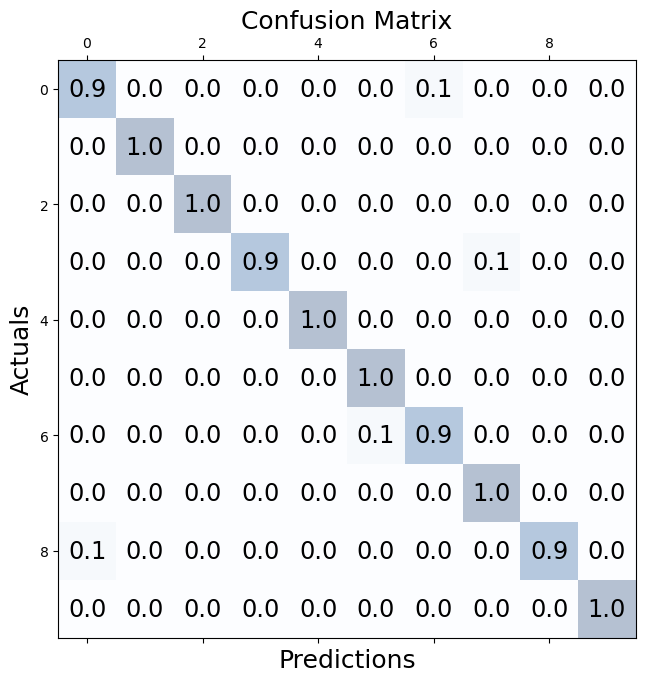

In [9]:
# # Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions, normalize='true')
# Create a figure and axis
fig, ax = plt.subplots(figsize=(7.5, 7.5))
# Display the confusion matrix as a color-coded matrix
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
# Add text annotations to each cell of the matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
# Set labels and title
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
# Display plot
plt.show()

In [10]:
import pandas as pd
import numpy as np
# import MLPClassifier
def digit_classify(testdata):
    """
    Classify digit(s) using the trained neural network model.

    Parameters:
    - testdata: Test data (DataFrame or NumPy array) containing 3D locations of finger tips
    - model_filename: Name of the file containing the saved model (default is 'model.pkl')

    Returns:
    - Predicted digit labels
    """
    X_test = []

    # Extract 3D location from the DataFrame or NumPy array
    if type(testdata) == pd.DataFrame:
        location = testdata.values[:, :3]
    elif type(testdata) == np.array or type(testdata) == np.ndarray:
        location = testdata
    else:
        raise ValueError("Input must be either a DataFrame or a NumPy array.")

    # Normalize the location using nearest neighbor averaging and root point normalization
    normalized_location = nearest_neighbor_point_normalization(location)
    normalized_location = root_point_normalization(normalized_location)

    # Pad the normalized location to the specified maximum length
    padded_location = pad_sequence(normalized_location)

    X_test.append(padded_location)
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Load the trained model from the file
    neural_net = MLP(input_size, hidden_size, output_size)
    neural_net.load_model('model.pkl')

    # Make predictions on the test data using the loaded model
    predictions = neural_net.predict(X_test)

    return predictions


In [11]:
testdata=pd.read_csv('training_data/stroke_6_0001.csv') # input path to file for test data
# Classify sequence
digit_classify(testdata)

Model loaded from model.pkl


array([6], dtype=int64)

In [12]:
testdata=pd.read_csv('training_data/stroke_5_0001.csv') # input path to file for test data
t=testdata.values
digit_classify(t)

Model loaded from model.pkl


array([5], dtype=int64)

In [13]:
# function C = digit_classify(testdata)
#     testdata = py,numpy.array(testdata);
#     C = pyrunfile("main.py", "C", testdata = testdata);
#     C = double(C);
# end